In [3]:
import pymatgen as pmg
from pymatgen.io.vasp.outputs import Vasprun
from pymatgen.electronic_structure.plotter import DosPlotter
from pymatgen.core.periodic_table import Element
from pymatgen.electronic_structure.core import Spin, Orbital
from pymatgen.electronic_structure.dos import Dos, DOS
import functools
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)


from os.path import expanduser
home = expanduser('~')

from matplotlib.pyplot import figure

import matplotlib.pyplot as pyplot
from scipy.integrate import trapz, simps, cumtrapz

import warnings
warnings.filterwarnings("ignore")


def integrate(axis, line_idx, start, end, label=None, down=False, color=None):
    """Integrates the given DoS data"""
    line = axis.get_lines()[line_idx]
    
    x = line.get_xdata()[:3001]
    y = line.get_ydata()[:3001]
    
    if down:
        x = np.flip(x)
        y = np.flip(y)
    
    integral = cumtrapz(y, x=x, initial=0)
    
    pyplot.plot(x,y, label=label, color=color)
    pyplot.plot(x, integral, color=color, linestyle='--', label=label+' int')
    pyplot.axvline(x=x[0], linestyle='--', color='grey')
    pyplot.axvline(x=x[-1], linestyle='--', color='grey')
    pyplot.axhline(y=0, color='k')
    pyplot.grid(1)
    pyplot.legend()


def norm_dos(dos, factor):
    dos_dict = dos.as_dict()
    for key in dos_dict['densities'].keys():
        dos_dict['densities'][key] = np.array(dos_dict['densities'][key])/factor
    return Dos.from_dict(dos_dict)

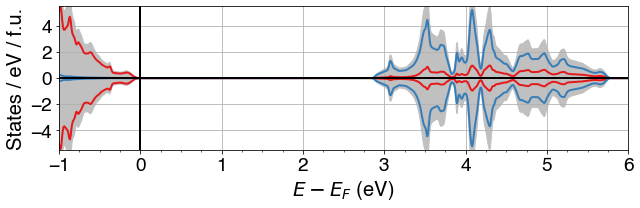

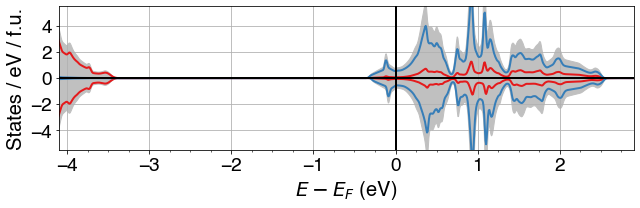

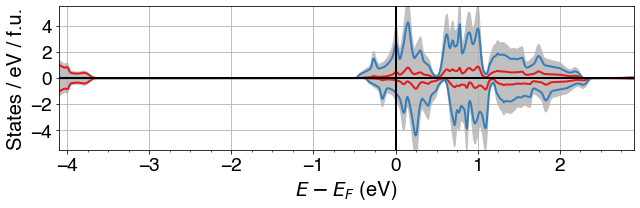

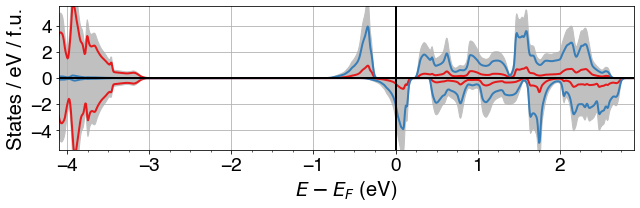

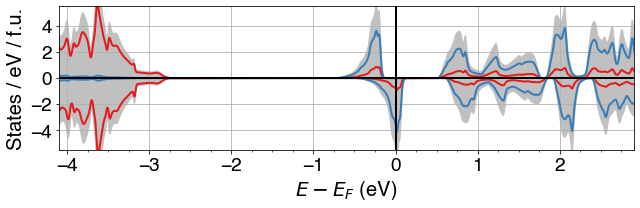

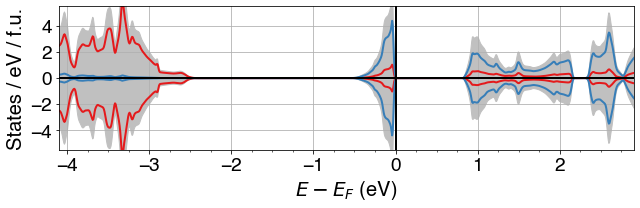

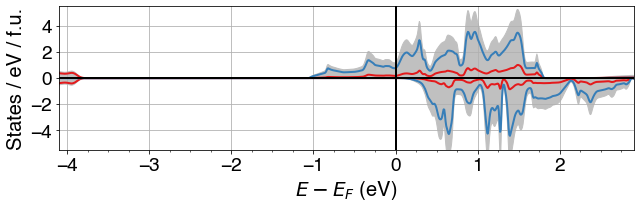

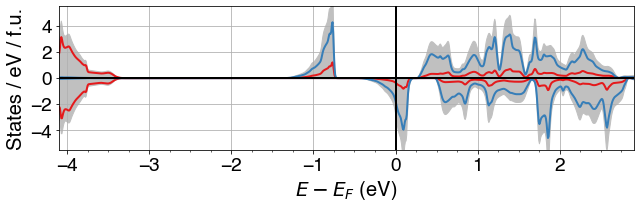

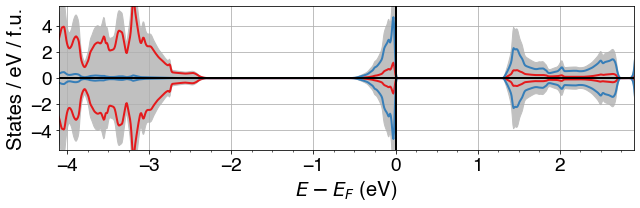

In [6]:
WIDTH = 9
HEIGHT = 3

DOS_TYPE = 'site' #'element'
BY_ELEMENT = ["Ta", "O"]
BY_SITE = []
ORBITALS_LS = [[4, 5, 6, 7, 8]] #desired orbitals corresponding to sites listed
NORM_FACTOR = 2
TOTAL = True

# PREFIX = home + "/Projects/trirutiles-study/carrier_doping/elec_dos/vasprun"
PREFIX = "/mnt/c/Users/kyledmiller/GoogleDrive/data/MgTa2O6/carrier_doping/is4-estruc/vasprun-dos"
SUFFIX = ".xml"
ITERS_1 = ["d0", "d025", "d05", "d065", "d08", "d1", 'U3-d05', 'U3-d065', 'U3-d1']
# ITERS_1 = ["d0", "d05", "d065", "d1", 'U3-d05', 'U3-d065', 'U3-d1']

LABEL_PREFIX = ""
# XLIMS = [[-1,4]] + [[-1,4]]*20 
XLIMS = [[-1,6]] + [[-4.1,2.9]]*20 
YLIMS = [[-5.5,5.5]]*20
LABEL_FONT = 20
            
axes = []

for i, iter_1 in enumerate(ITERS_1):
#     for j, iter_2 in enumerate(ITERS_2):
        
        label = f'{iter_1}'
        
            # Extract dos from vasprun
        vr = Vasprun(f'{PREFIX}-{label}{SUFFIX}')
        cdos = vr.complete_dos
        tdos = norm_dos(vr.tdos, NORM_FACTOR)
        
        dplt = DosPlotter(sigma=0.01)

            # Add total dos
        if TOTAL:
            dplt.add_dos("Total", tdos)
        
            # Add site doss spin-separated
        if DOS_TYPE == 'site-spin':
            pdoss = cdos.pdos
            for site_idx, orbitals in zip(BY_SITE, ORBITALS_LS):
#                 if iter_1 == 'P2c':
#                     site_idx = 11

                site = cdos.structure[site_idx]
                elem = site.species.elements[0]
                efermi = cdos.efermi
                energies = cdos.energies


                for spin, spin_label in [(Spin.up, 'up'), (Spin.down, 'down')]:
                    print(site)
                    spin_doss = (pdoss[site][Orbital(orb_num)][spin] for orb_num in orbitals)
                    dplt.add_dos(f'{elem}-{spin_label}', 
                                 Dos(efermi, energies, {spin: sum(spin_doss)}))
                
            # Add site doss spin-separated and avged across listed sites
        if DOS_TYPE == 'site-sum':
            pdoss = cdos.pdos
            
            if iter_1 == 'sm-P2c':
                site_groups = [[4,5], [6,7]]
            else:
                site_groups = BY_SITE
            
            for j, site_ls in enumerate(site_groups):
            
                up_pdoss = []
                down_pdoss = []
                elem, efermi, energies = None, None, None            

                for site_idx, orbitals in zip(site_ls, ORBITALS_LS):

                    site = cdos.structure[site_idx]
                    elem = site.species.elements[0]
                    efermi = cdos.efermi
                    energies = cdos.energies

                    for spin, spin_label in [(Spin.up, 'up'), (Spin.down, 'down')]:
                        spin_doss = (pdoss[site][Orbital(orb_num)][spin] for orb_num in orbitals)
                        if spin_label == 'up':
                            up_pdoss.append(sum(spin_doss))
                        else:
                            down_pdoss.append(sum(spin_doss))

                dplt.add_dos(f'{elem}-{j+1}', 
                             Dos(efermi, energies, {Spin.up: sum(up_pdoss)/len(site_ls), 
                                                    Spin.down: sum(down_pdoss)/len(site_ls)}))
            
                
        if DOS_TYPE == 'site':
            for site_idx in BY_SITE:
                site = cdos.structure[site_idx]
                elem = cdos.structure[2].species.elements[0]
                dos = cdos.get_site_dos(site)
                dplt.add_dos(elem, dos)

            # Add element dos
        elem_doss = cdos.get_element_dos()
        for element in BY_ELEMENT:
            dplt.add_dos(element, norm_dos(elem_doss[Element(element)], NORM_FACTOR))

            # Customize plot
        dos_plot = dplt.get_plot()
        ax = dos_plot.gca()
        dos_plot.xlim(XLIMS[i])
        dos_plot.ylim(YLIMS[i])
        dos_plot.axvline(x=0, color='k', linestyle='-')
        dos_plot.axhline(y=0, color='k', linestyle='-')
        dos_plot.grid(1)
        dos_plot.gca().get_legend().remove()
        #legend(loc='upper right', ncol=6, fontsize=LABEL_FONT-3) #keep line thick in legend

            # Customize colors
#         ax.get_lines()[0].set_color('C2')
#         ax.get_lines()[2].set_color('C0')
#         ax.get_lines()[1].set_color('C3')
        
        
            # Make total line grey and filled in
        if TOTAL:
            totLine = dos_plot.gca().get_lines()[2]
            totLine.set_color((0,0,0,0))
            totX = totLine.get_xdata()
            totY = totLine.get_ydata()
            dos_plot.fill_between(totX, totY, where=totY>=-totY, interpolate=True, color='silver')
            dos_plot.fill_between(totX, totY, where=totY<=-totY, interpolate=True, color='silver')

            # Add a label to bottom right
#         t = dos_plot.text(0.0, 0.0, LABEL_PREFIX + label, horizontalalignment='left', 
#                       verticalalignment='bottom', transform=dos_plot.gca().transAxes, 
#                       fontsize=24, color='grey')
#         t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='grey'))
            # Chance font size
        dos_plot.gca().xaxis.label.set_fontsize(LABEL_FONT)
        dos_plot.gca().yaxis.label.set_fontsize(LABEL_FONT)
        pyplot.xticks(fontsize=LABEL_FONT-1)
        pyplot.yticks(fontsize=LABEL_FONT-1)

            # Customize axes
#         ax.xaxis.label.set_visible(False)
#         ax.set_xticklabels([])
#         ax.set_yticklabels([])
        ax.xaxis.set_minor_locator(MultipleLocator(0.25))
        ax.set_ylabel('States / eV / f.u.')#, rotation=270, verticalalignment='top')
        ax.set_xlabel('$E - E_F$ (eV)')#, rotation=270, verticalalignment='top')
        
        
        ### Make lines thinner
        for line in ax.get_lines():
            line.set_linewidth(2)
            
            # Add axes to persistent list
        axes.append(dos_plot.gca())

            # Resize/reshape
        fig = dos_plot.gcf()
        fig.set_size_inches(WIDTH,HEIGHT)

            # Show and save
        dos_plot.tight_layout()
        dos_plot.show()
        fig.savefig(f"elec_dos-pub-{label}.png", img_format="png", dpi=300)
#         fig.savefig(f"elec_dos-full-vec-{label}.pdf", img_format="pdf")

NOTE: The total is 12 states because the POTCAR includes the 6s1 state


TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

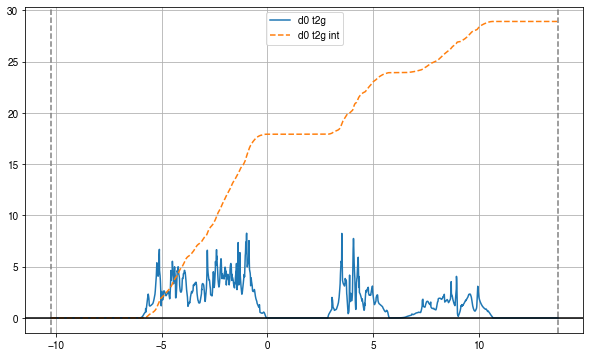

In [7]:
start = 1150
end = 1220

# print(f'd1 - {integrate(axes[-1], start, end)}')
# print(f'd065 - {integrate(axes[5], 1250, 1350)}')

# spin-polarized (dos is halved) and 2 Ta per f.u., 2 f.u. per u.c. 
line_idx = 2

print('NOTE: The total is 12 states because the POTCAR includes the 6s1 state')

fig = pyplot.figure(figsize=(10,6))
print(f'd0 t2g? - {integrate(axes[0], line_idx, 1300, 1750, label="d0 t2g")*2/4} states/Ta')
print(f'd0 eg? - {integrate(axes[0], line_idx, 1750, 2350, label="d0 eg")*2/4} states/Ta')

fig = pyplot.figure(figsize=(10,6))
print(f'd1 singlet - {integrate(axes[-1], line_idx, 1150, 1220, label="d1 singlet")*2/4} states/Ta')
print(f'd1 rest - {integrate(axes[-1], line_idx, 1220, 2050, label="d1 rest")*2/4} states/Ta')
pyplot.ylim([0,12])